In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, r_regression
from torch.utils.data import DataLoader, Dataset, TensorDataset, WeightedRandomSampler
from sklearn.metrics import RocCurveDisplay, f1_score, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# There are eight datasets in total. They can be found here: https://www.kaggle.com/datasets/cicdataset/cicids2017

import warnings
warnings.filterwarnings("ignore")
    

There are eight datasets in total. They can be found here: https://www.kaggle.com/datasets/cicdataset/cicids2017

In [3]:
df1=pd.read_csv("Wednesday-workingHours.pcap_ISCX.csv")
df2=pd.read_csv("Tuesday-WorkingHours.pcap_ISCX.csv")
df3=pd.read_csv("Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df4=pd.read_csv("Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df5=pd.read_csv("Monday-WorkingHours.pcap_ISCX.csv")
df6=pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df7=pd.read_csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df8=pd.read_csv("Friday-WorkingHours-Morning.pcap_ISCX.csv")


df = pd.concat([df1,df2, df3, df4, df5, df6, df7, df8])
del df1
del df2
del df3
del df4
del df5
del df6
del df7
del df8

print(df.shape)

(2830743, 79)


In [6]:
# Drop columns that are completely homogenous

df_nums = df.select_dtypes(include=[np.number])
print("The columns that are completely homogenous are")
for col in df_nums.columns:
    if (df_nums[col].max()-df_nums[col].min() == 0):
        print(col,)
df.drop([col for col in df_nums.columns if df_nums[col].max()-df_nums[col].min() == 0], axis=1, inplace=True)
print(df.shape)


The columns that are completely homogenous are
 Bwd PSH Flags
 Bwd URG Flags
Fwd Avg Bytes/Bulk
 Fwd Avg Packets/Bulk
 Fwd Avg Bulk Rate
 Bwd Avg Bytes/Bulk
 Bwd Avg Packets/Bulk
Bwd Avg Bulk Rate
(2830743, 71)


In [7]:
df.head(5)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [8]:
df1=df.copy()
df1.shape

(2830743, 71)

In [9]:
df1.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [10]:
# Drop NA rows

df1.dropna(axis=0, inplace=True)
print(df1.shape)

(2829385, 71)


In [11]:
print("There are", df.shape[0]-df1.shape[0],"rows that contains null value and are dropped")

There are 1358 rows that contains null value and are dropped


In [12]:
# Normalization
df_nums = df1.select_dtypes(include=[np.number])
df_nums = (df_nums-df_nums.min())/(df_nums.max()-df_nums.min())

for col in df_nums.columns:
    df1[col] = df_nums[col]

df1.dropna(axis=0, inplace=True)
for c in df1.columns:
    print(c + " :", df1[c].isna().sum())

 Destination Port : 0
 Flow Duration : 0
 Total Fwd Packets : 0
 Total Backward Packets : 0
Total Length of Fwd Packets : 0
 Total Length of Bwd Packets : 0
 Fwd Packet Length Max : 0
 Fwd Packet Length Min : 0
 Fwd Packet Length Mean : 0
 Fwd Packet Length Std : 0
Bwd Packet Length Max : 0
 Bwd Packet Length Min : 0
 Bwd Packet Length Mean : 0
 Bwd Packet Length Std : 0
Flow Bytes/s : 0
 Flow Packets/s : 0
 Flow IAT Mean : 0
 Flow IAT Std : 0
 Flow IAT Max : 0
 Flow IAT Min : 0
Fwd IAT Total : 0
 Fwd IAT Mean : 0
 Fwd IAT Std : 0
 Fwd IAT Max : 0
 Fwd IAT Min : 0
Bwd IAT Total : 0
 Bwd IAT Mean : 0
 Bwd IAT Std : 0
 Bwd IAT Max : 0
 Bwd IAT Min : 0
Fwd PSH Flags : 0
 Fwd URG Flags : 0
 Fwd Header Length : 0
 Bwd Header Length : 0
Fwd Packets/s : 0
 Bwd Packets/s : 0
 Min Packet Length : 0
 Max Packet Length : 0
 Packet Length Mean : 0
 Packet Length Std : 0
 Packet Length Variance : 0
FIN Flag Count : 0
 SYN Flag Count : 0
 RST Flag Count : 0
 PSH Flag Count : 0
 ACK Flag Count : 0
 U

In [13]:
df1.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0.001221,0.000319,0.000000,0.000003,4.651163e-07,9.153974e-09,0.000242,0.002581,0.001010,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,0.005936,0.000004,0.000046,0.000017,1.333333e-05,4.973659e-07,0.003183,0.000000,0.002632,0.004414,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,0.001343,0.000009,0.000041,0.000021,2.441860e-04,4.805836e-06,0.063457,0.000000,0.053023,0.088773,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,0.005936,0.000127,0.000073,0.000041,2.675969e-04,1.016091e-05,0.052901,0.000000,0.034180,0.059753,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,0.001343,0.000009,0.000036,0.000021,2.441860e-04,4.808888e-06,0.063457,0.000000,0.058914,0.097467,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


## To avoid class imbalalance problem,drop the classes with less than 40 samples

In [14]:
df1.drop(df1[df1[' Label'] == "Web Attack � Sql Injection"].index, inplace=True)
df1.drop(df1[df1[' Label'] == "Heartbleed"].index, inplace=True)
df1.drop(df1[df1[' Label'] == "Infiltration"].index, inplace=True)

In [15]:
df1.shape

(2827425, 71)

In [16]:
print("there are ",df_nums.shape[0]-df1.shape[0],"samples that are deleted to tackle missing values and avoid class imbalance problem")

there are  1960 samples that are deleted to tackle missing values and avoid class imbalance problem


In [17]:
# 1 denotes OOD, 0 denotes ID

ood_cats = ["Web Attack � Brute Force", "Web Attack � XSS"]
def mark_ood(row):
    if row[' Label'] in ood_cats: row['ood'] = 1
    else: row['ood'] = 0
    return row



df1 = df1.apply(mark_ood, axis=1)

In [18]:
print(df1.shape)


(2827425, 72)


In [19]:
df1.head(5)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,ood
0,0.001221,0.000319,0.000000,0.000003,4.651163e-07,9.153974e-09,0.000242,0.002581,0.001010,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0
1,0.005936,0.000004,0.000046,0.000017,1.333333e-05,4.973659e-07,0.003183,0.000000,0.002632,0.004414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0
2,0.001343,0.000009,0.000041,0.000021,2.441860e-04,4.805836e-06,0.063457,0.000000,0.053023,0.088773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0
3,0.005936,0.000127,0.000073,0.000041,2.675969e-04,1.016091e-05,0.052901,0.000000,0.034180,0.059753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0
4,0.001343,0.000009,0.000036,0.000021,2.441860e-04,4.808888e-06,0.063457,0.000000,0.058914,0.097467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0


In [20]:
# Split the dataset into train, test, OOD

df_temp_X = df1.drop([' Label'], axis=1)
df_temp_y = df1[[' Label', 'ood']]
df_temp_X = pd.get_dummies(df_temp_X)

X = df_temp_X[df_temp_X['ood'] == 0]
X.drop(['ood'], inplace=True, axis=1)

y = df_temp_y[df_temp_y['ood'] == 0]
y.drop(['ood'], inplace=True, axis=1)
y = pd.get_dummies(y)

X_ood = df_temp_X[df_temp_X['ood'] == 1]
X_ood.drop(['ood'], inplace=True, axis=1)
ood_len = len(X_ood)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X.values, y.values, test_size=0.2)
X_train = torch.FloatTensor(X_train1)
X_test = torch.FloatTensor(X_test1)
y_train = torch.FloatTensor(y_train1)
y_test = torch.FloatTensor(y_test1)
X_ood = torch.FloatTensor(np.concatenate((X_test[:150], X_ood.values), axis=0))
y_ood = torch.FloatTensor([1 for j in range(len(X_test[:150]))] + [0 for i in range(ood_len)]) # 1 == ID, 0 == OOD

weightlist = [1 / y[col].sum() for col in y.columns]
samp = WeightedRandomSampler(weights=[weightlist[cat.argmax()] for cat in y_train], num_samples=len(y_train), replacement=True)

train = TensorDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size=512, sampler=samp)

test = TensorDataset(X_test, y_test)
test_loader = DataLoader(test, batch_size=512)

ood = TensorDataset(X_ood, y_ood)
ood_loader = DataLoader(ood, batch_size=512)

In [21]:
# Verify the distribution of attack classes are uniform

from collections import defaultdict
store = defaultdict(int)
for x, y in train_loader:
    for val in y:
        
        
        store[int(val.argmax(0))] += 1
    break
for key in store:
    print(key, store[key])

5 64
7 46
4 52
0 41
9 49
8 58
3 57
6 43
1 55
2 47


In [22]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([512, 70])
torch.Size([512, 10])


In [23]:
# Neural network

class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=70, out_features=128)
        self.norm = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.norm2 = nn.BatchNorm1d(128)
        self.output = nn.Linear(in_features=128, out_features=10)
        #self.output2 = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.norm(x)
        x = F.relu(self.fc2(x))
        x = self.norm2(x)
        #x = self.norm4(x)
        x = self.output(x)
        #x = self.output2(x)
        return x

model = ANN()
model

ANN(
  (fc1): Linear(in_features=70, out_features=128, bias=True)
  (norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

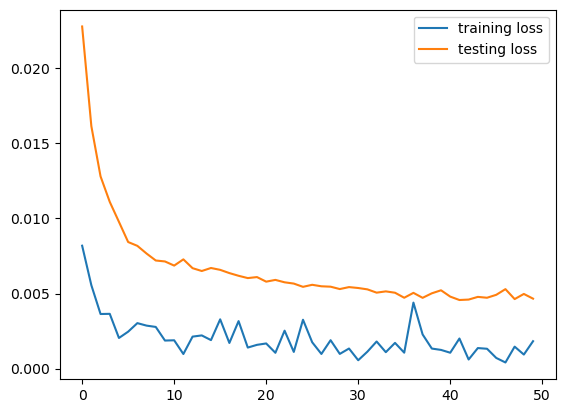

In [28]:
# Training phase

epochs = 50
lossarr = []
size = len(test_loader.dataset)
num_batches = len(test_loader)
testloss = []
for i in range(epochs):
    model.train()
    for batch, (x, y) in enumerate(train_loader):
        y_hat = model.forward(x)
        loss = criterion(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lossarr.append(loss.item())
    
    model.eval()
    test_loss, correct = 0, 0
    preds = []
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            preds.extend(pred)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    testloss.append(test_loss/num_batches)

plt.plot(list(range(epochs)), lossarr, label="training loss")
plt.plot(list(range(epochs)), testloss, label="testing loss")

plt.legend()
plt.show()

In [29]:
lossarr

[0.008185640908777714,
 0.005552751012146473,
 0.0036330455914139748,
 0.0036445665173232555,
 0.00203531701117754,
 0.002456025453284383,
 0.003025173442438245,
 0.002859630389139056,
 0.0027714448515325785,
 0.0018638044130057096,
 0.0018821097910404205,
 0.0009670527069829404,
 0.0021262620575726032,
 0.002206481294706464,
 0.0018938243156298995,
 0.003278670832514763,
 0.0017031447496265173,
 0.003159984713420272,
 0.0013968057464808226,
 0.0015782880363985896,
 0.0016705960733816028,
 0.0010486992541700602,
 0.002522716298699379,
 0.0011067991144955158,
 0.003250986570492387,
 0.001749617513269186,
 0.0009712865576148033,
 0.0018869059858843684,
 0.0009741129470057786,
 0.0013327067717909813,
 0.0005517635145224631,
 0.0011242515174672008,
 0.0018004870507866144,
 0.0010896915337070823,
 0.0017082642298191786,
 0.001056723645888269,
 0.004393015522509813,
 0.00227014790289104,
 0.0013301087310537696,
 0.0012405379675328732,
 0.0010524779791012406,
 0.002000145148485899,
 0.0006012

In [30]:
testloss

[0.022797060366112575,
 0.016155499877219183,
 0.012807175600597553,
 0.011108134002627237,
 0.009774213451369113,
 0.008430627296574117,
 0.008176207401961818,
 0.007663164688510469,
 0.007199675252195448,
 0.0071364800476104665,
 0.006860208195259633,
 0.007275316098694811,
 0.006687955760845806,
 0.006499828735958663,
 0.006700143176493694,
 0.0065764053334546125,
 0.006360582029826574,
 0.0061807824354416325,
 0.006027610517407268,
 0.006094218966925679,
 0.005789775371195519,
 0.005906751140845818,
 0.005746362399962812,
 0.005661461226459916,
 0.005444406443596075,
 0.005580085029182753,
 0.005480954732722265,
 0.005454187619709072,
 0.005296305882570712,
 0.00542694893965086,
 0.005366323204066577,
 0.005275606457186202,
 0.005056414043740032,
 0.00514166888361628,
 0.005051329772960752,
 0.004717722347329296,
 0.005043028313620185,
 0.004712368915151919,
 0.005012970203888076,
 0.005214237225236898,
 0.004793059805376907,
 0.004565920533765904,
 0.0045952932999606,
 0.004774345

In [31]:
# Testing phase

size = len(test_loader.dataset)
num_batches = len(test_loader)
model.eval()
test_loss, correct = 0, 0
preds = []
cm=[]
with torch.no_grad():
    for X, y in test_loader:
        pred = model(X)
        preds.extend(pred)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.004657 



In [32]:
from collections import defaultdict
store = defaultdict(int)
for x, y in test_loader:
    for val in y:
        store[int(val.argmax(0))] += 1
for key in store:
    print(key, store[key])

0 454637
4 46179
2 25400
5 1048
8 31527
6 1187
7 1528
3 1964
9 1177
1 407


F1 score for Class 0 : 0.9849230188788762
F1 score for Class 1 : 0.20917053065430188
F1 score for Class 2 : 0.9987605500796789
F1 score for Class 3 : 0.9360381861575179
F1 score for Class 4 : 0.9743421886218694
F1 score for Class 5 : 0.9213085764809903
F1 score for Class 6 : 0.9562753036437247
F1 score for Class 7 : 0.9947882736156353
F1 score for Class 8 : 0.9057776115753592
F1 score for Class 9 : 0.7106937291729779


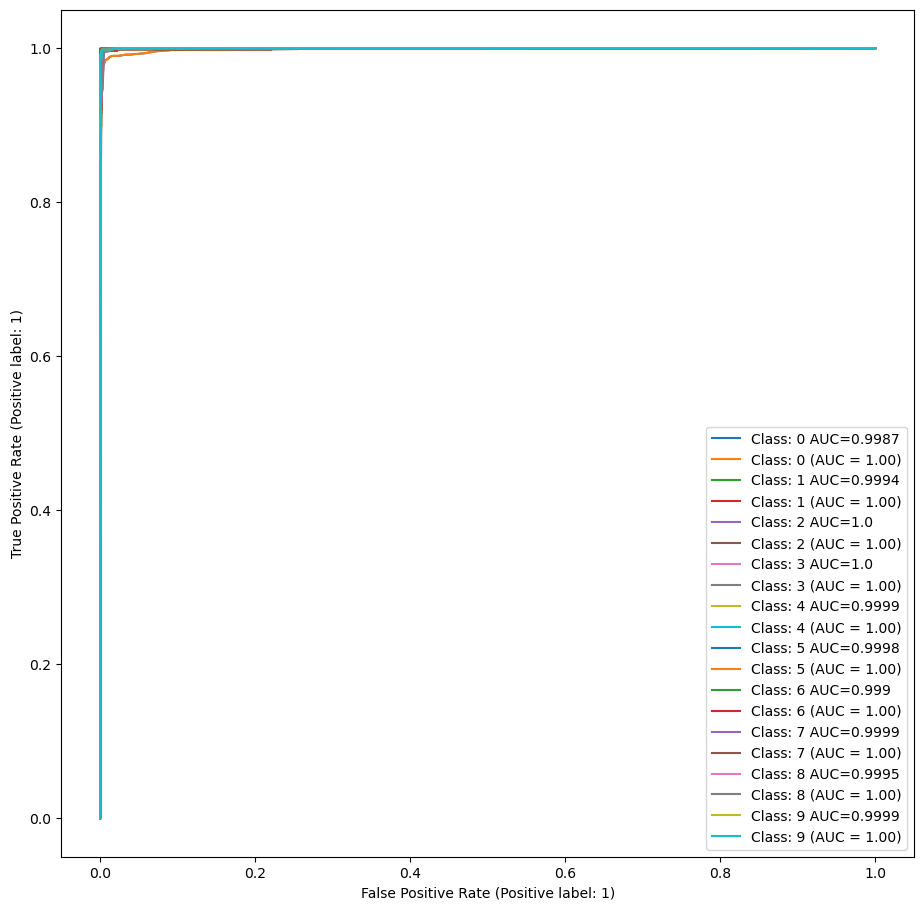

In [34]:
# Plot ROC curve
from sklearn import metrics

plt.figure(figsize=(11,11))
ax = plt.gca()
sm = nn.Softmax(dim=0)
for atk in range(10):
    labels = [int(val[atk]) for X, y in test_loader for val in y]
    probs = [float(sm(tensor)[atk]) for tensor in preds]
    fpr, tpr, thresholds = metrics.roc_curve(labels, probs)
    auc = round(metrics.roc_auc_score(labels,probs), 4)
    plt.plot(fpr,tpr,label=f"Class: {atk} AUC="+str(auc))
    RocCurveDisplay.from_predictions(labels, probs, name=f"Class: {atk}",ax=ax)
    print(f"F1 score for Class {atk} :", f1_score(labels, [int(int(tensor.argmax(0)) == atk) for tensor in preds]))
    plt.legend()

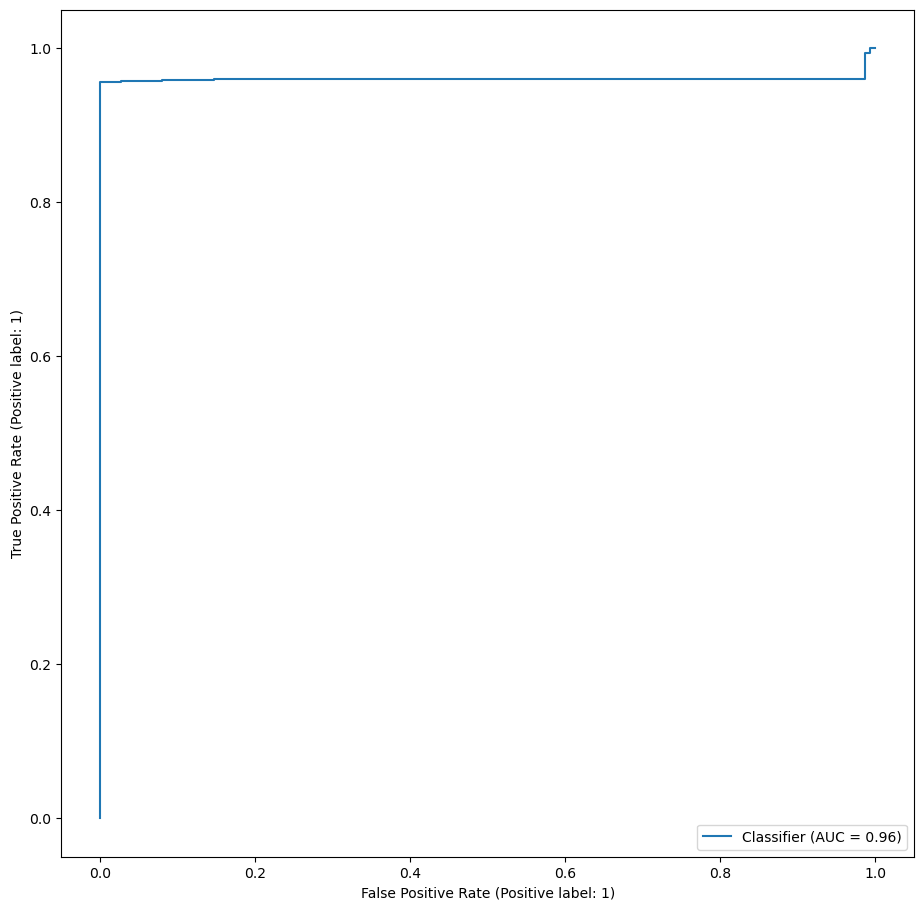

In [35]:
# ROC for OOD evaluation. Positive class is OOD

model.eval()
preds = []
sm = nn.Softmax(dim=0)
labels = []
with torch.no_grad():
    for X, y in ood_loader:
        pred = model(X)
        preds.extend(pred)
        labels.extend(y)

plt.figure(3, figsize=(11,11))
ax = plt.gca()
msp = [-float(max(sm(tensor))) for tensor in preds]
RocCurveDisplay.from_predictions([0 if i == 1 else 1 for i in labels], msp, ax=ax)
plt.show(3)


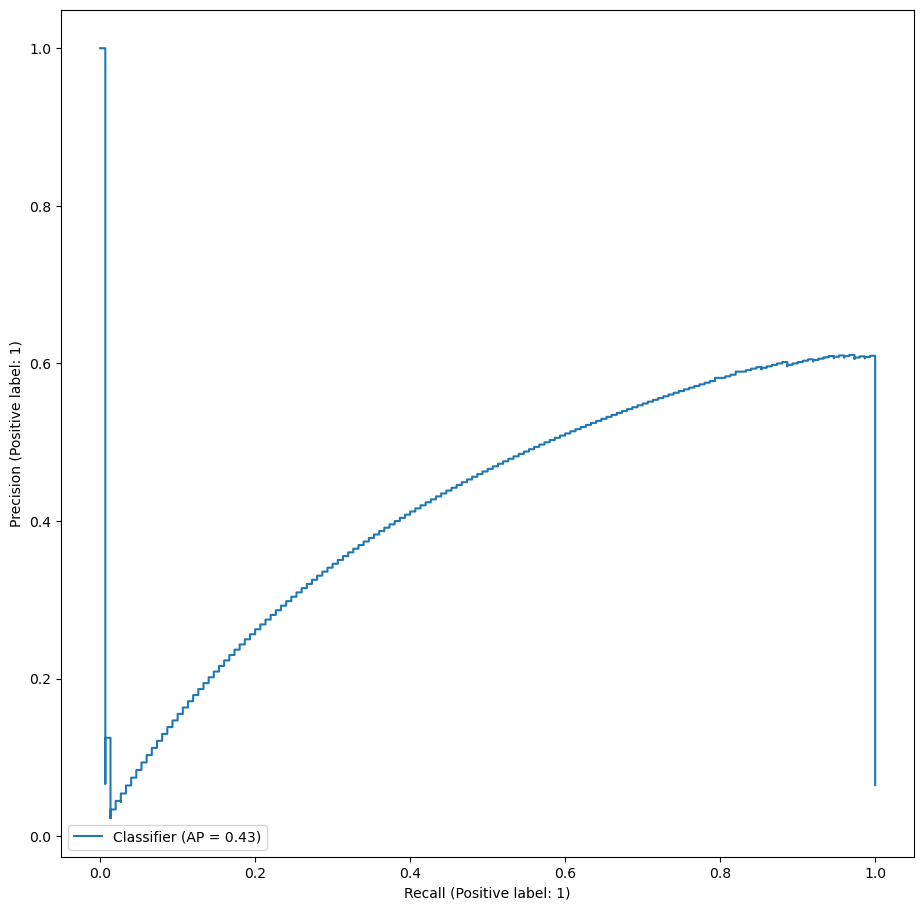

In [36]:
# PR for OOD evaluation. Positive class is ID

model.eval()
preds = []
sm = nn.Softmax(dim=0)
labels = []
with torch.no_grad():
    for X, y in ood_loader:
        pred = model(X)
        preds.extend(pred)
        labels.extend(y)

plt.figure(4, figsize=(11,11))
ax = plt.gca()
msp = [float(max(sm(tensor))) for tensor in preds]
PrecisionRecallDisplay.from_predictions(labels, msp, ax=ax)
plt.show(4)

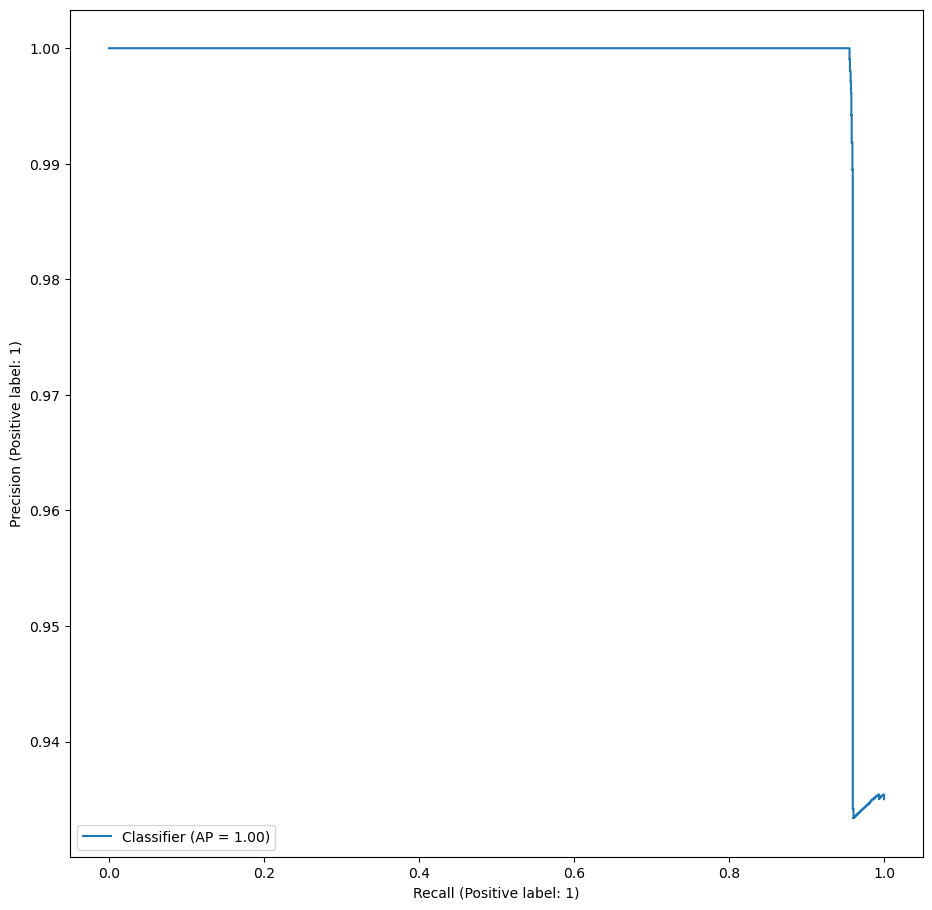

In [37]:
# PR for OOD evaluation. Positive class is OOD

model.eval()
preds = []
sm = nn.Softmax(dim=0)
labels = []
with torch.no_grad():
    for X, y in ood_loader:
        pred = model(X)
        preds.extend(pred)
        labels.extend(y)

plt.figure(3, figsize=(11,11))
ax = plt.gca()
msp = [-float(max(sm(tensor))) for tensor in preds]
PrecisionRecallDisplay.from_predictions([0 if i == 1 else 1 for i in labels], msp, ax=ax)
plt.show(3)